# HW 3.1 VAEs in 2D

In [1]:
import os
import pickle

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

## Part A

In [2]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
    [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

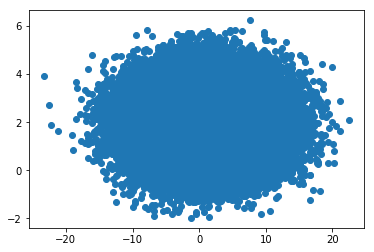

In [3]:
dataset1 = sample_data_1()

plt.plot(dataset1[:, 0], dataset1[:, 1], 'o')
plt.show()

n = dataset1.shape[0]
n_train = int(n * 0.8)
xs1_train, xs1_val = dataset1[:n_train], dataset1[n_train:]

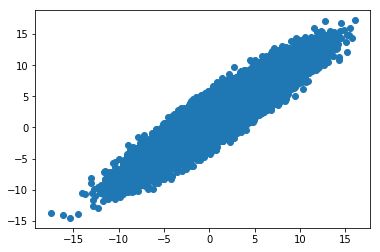

In [4]:
dataset2 = sample_data_2()

plt.plot(dataset2[:, 0], dataset2[:, 1], 'o')
plt.show

n = dataset2.shape[0]
n_train = int(n * 0.8)
xs2_train, xs2_val = dataset2[:n_train], dataset2[n_train:]

In [5]:
batch_size = 10000

def collate_fn(data):
    xs = data
    xs = torch.tensor(xs, dtype=torch.float32)
    return xs

train_data1_loader = data.DataLoader(
    dataset=xs1_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data1_loader = data.DataLoader(
    dataset=xs1_val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

train_data2_loader = data.DataLoader(
    dataset=xs2_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data2_loader = data.DataLoader(
    dataset=xs2_val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [6]:
class MLP(nn.Module):
    def __init__(self, layer_dims, activ=nn.ReLU, last_active=False, dropout_rate=0):
        super(MLP, self).__init__()

        layers = []
        in_dim, layer_dims = layer_dims[0], layer_dims[1:]
        for dim in layer_dims[:-1]:
            layers += [
                nn.Linear(in_dim, dim),
                activ(),
                nn.Dropout(dropout_rate)
            ]
            in_dim = dim

        layers += [nn.Linear(in_dim, layer_dims[-1])]
        if last_active:
            layers += [activ()]
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer(x)
        return x

Первая модель

In [7]:
class Net1(nn.Module):
    def __init__(self, layer_dims):
        super(Net1, self).__init__()
        
        self.mlp_encoder = MLP(layer_dims)
        self.mlp_decoder = MLP(layer_dims)
        
    def get_mu_var(self, mlp, x):
        x = mlp(x)
        mu, log_var = x[:, :2], x[:, 2:]
        var = torch.exp(log_var)
        return mu, var
            
    def encode(self, x):
        return self.get_mu_var(self.mlp_encoder, x)
    
    def reparameterize(self, mu, var):
        eps = torch.randn_like(mu).to(device)
        z = mu + eps * torch.sqrt(var)
        return z
    
    def decode(self, z):
        return self.get_mu_var(self.mlp_decoder, z)
            
    def forward(self, x):
        mu_z, var_z = self.encode(x)
        z = self.reparameterize(mu_z, var_z)
        mu_x, var_x = self.decode(z)
        return mu_z, var_z, mu_x, var_x

Вторая модель

In [8]:
class Net2(nn.Module):
    def __init__(self, layer_dims):
        super(Net2, self).__init__()
        
        self.mlp_encoder = MLP(layer_dims)
        self.mlp_decoder = MLP(layer_dims)
        
    def get_mu_var(self, mlp, x):
        x = mlp(x)
        mu, log_var = x[:, :2], x[:, 2:]
        log_var = log_var.expand(-1, 2)
        var = torch.exp(log_var)
        return mu, var
            
    def encode(self, x):
        return self.get_mu_var(self.mlp_encoder, x)
    
    def reparameterize(self, mu, var):
        eps = torch.randn_like(mu).to(device)
        z = mu + eps * torch.sqrt(var)
        return z
    
    def decode(self, z):
        return self.get_mu_var(self.mlp_decoder, z)
            
    def forward(self, x):
        mu_z, var_z = self.encode(x)
        z = self.reparameterize(mu_z, var_z)
        mu_x, var_x = self.decode(z)
        return mu_z, var_z, mu_x, var_x

In [9]:
class ProbLoss(nn.Module):
    def __init__(self):
        super(ProbLoss, self).__init__()
        
    def forward(self, x, mu, var):
        prob = -0.5 * (torch.log(np.pi * 2 * var) + torch.pow(x - mu, 2) / var)
        loss = -prob.sum(dim=1)
        loss = loss.mean()
        return loss

In [10]:
class KLLoss(nn.Module):
    def __init__(self):
        super(KLLoss, self).__init__()
        
    def forward(self, mu, var):
        kl_div = 1.0 + torch.log(var) - mu ** 2 - var
        kl_div = -0.5 * kl_div
        loss = kl_div.sum(dim=1)
        loss = loss.mean()
        return loss

In [11]:
def train(model, criterion_prob, criterion_kl,
          optimizer, scheduler, epochs,
          train_data_loader, val_data_loader):
    losses_prob_train = []
    losses_kl_train = []
    losses_train = []
    losses_prob_val = []
    losses_kl_val = []
    losses_val = []
    for i in trange(epochs):
        losses_prob = []
        losses_kl = []
        losses = []
        model.train()
        for xs in train_data_loader:
            if len(xs) == 2:
                xs, _ = xs
                
            xs = xs.to(device)
            
            optimizer.zero_grad()

            mu_z, var_z, mu_x, var_x = model(xs)
            
            loss_prob = criterion_prob(xs, mu_x, var_x)
            loss_kl = criterion_kl(mu_z, var_z)
            loss = loss_prob + loss_kl

            losses_prob.append(loss_prob.item())
            losses_kl.append(loss_kl.item())
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_prob_train.append(np.array(losses_prob).mean())
        losses_kl_train.append(np.array(losses_kl).mean())
        losses_train.append(np.array(losses).mean())

        losses_prob = []
        losses_kl = []
        losses = []
        model.eval()
        with torch.no_grad():
            for xs in val_data_loader:
                if len(xs) == 2:
                    xs, _ = xs

                xs = xs.to(device)

                mu_z, var_z, mu_x, var_x = model(xs)

                loss_prob = criterion_prob(xs, mu_x, var_x)
                loss_kl = criterion_kl(mu_z, var_z)
                loss = loss_prob + loss_kl

                losses_prob.append(loss_prob.item())
                losses_kl.append(loss_kl.item())
                losses.append(loss.item())

        losses_prob_val.append(np.array(losses_prob).mean())
        losses_kl_val.append(np.array(losses_kl).mean())
        losses_val.append(np.array(losses).mean())
        
        if scheduler:
            scheduler.step()

    plt.plot(range(epochs), losses_prob_train, label="train")
    plt.plot(range(epochs), losses_prob_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss prob')
    plt.legend()
    plt.show()

    plt.plot(range(epochs), losses_kl_train, label="train")
    plt.plot(range(epochs), losses_kl_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss KL')
    plt.legend()
    plt.show()

    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [12]:
def sample(model, n=100000):
    with torch.no_grad():
        z = torch.randn([n, 2], device=device)
        mu_x, var_x = model.decode(z)
        eps = torch.randn([n, 2], device=device)
        x = eps * torch.sqrt(var_x) + mu_x
        mu_x = mu_x.cpu().numpy()
        x = x.cpu().numpy()
        
    plt.plot(x[:, 0], x[:, 1], 'o', label="X")
    plt.plot(mu_x[:, 0], mu_x[:, 1], 'o', label="Mean")
    plt.legend()
    plt.show()

Первая модель, первый датасет

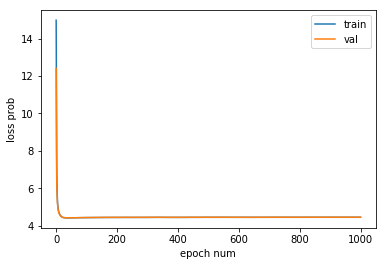

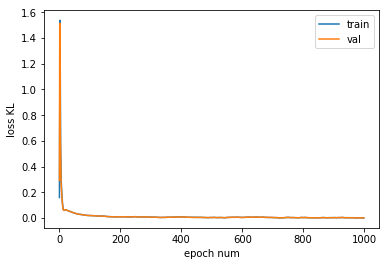

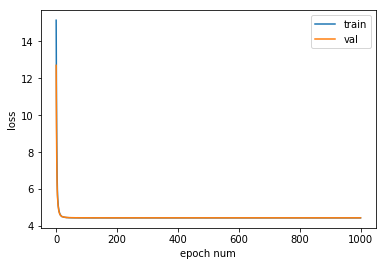

In [13]:
epochs = 1000
lr = 0.001
w_l2 = 0

model = Net1([2, 64, 64, 4])
model.to(device)

criterion_prob = ProbLoss()
criterion_kl = KLLoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion_prob, criterion_kl,
      optimizer, None, epochs,
      train_data1_loader, val_data1_loader)

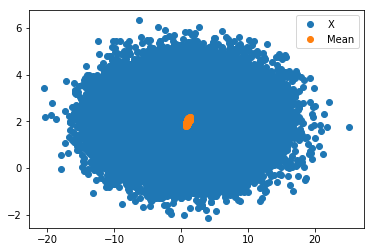

In [14]:
model.eval()
sample(model)

Первая модель, второй датасет

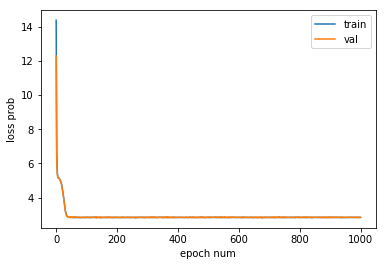

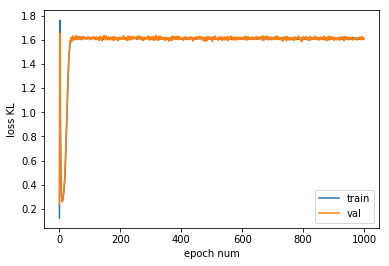

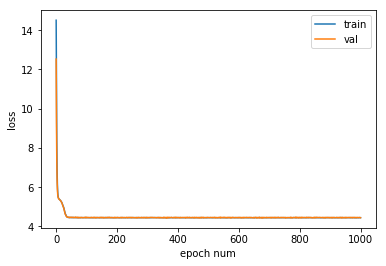

In [15]:
epochs = 1000
lr = 0.001
w_l2 = 0

model = Net1([2, 64, 64, 4])
model.to(device)

criterion_prob = ProbLoss()
criterion_kl = KLLoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion_prob, criterion_kl,
      optimizer, None, epochs,
      train_data2_loader, val_data2_loader)

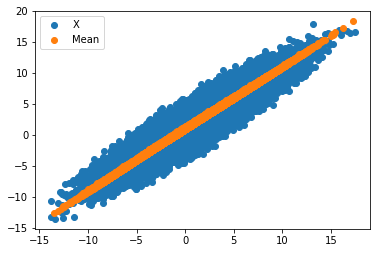

In [16]:
model.eval()
sample(model)

Вторая модель, первый датасет

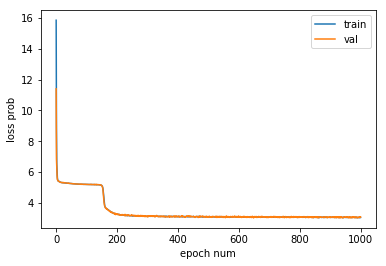

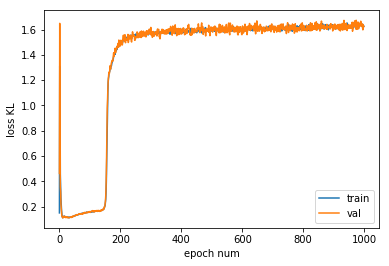

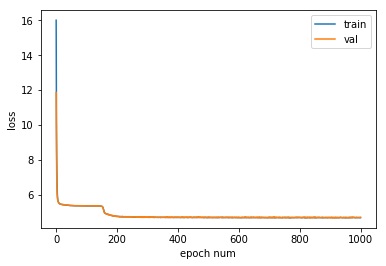

In [17]:
epochs = 1000
lr = 0.001
w_l2 = 0

model = Net2([2, 64, 64, 3])
model.to(device)

criterion_prob = ProbLoss()
criterion_kl = KLLoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion_prob, criterion_kl,
      optimizer, None, epochs,
      train_data1_loader, val_data1_loader)

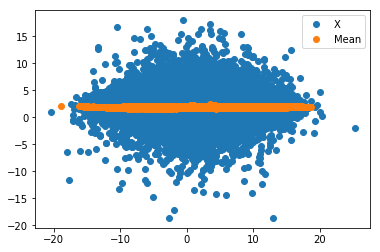

In [18]:
model.eval()
sample(model)

Вторая модель, второй датасет

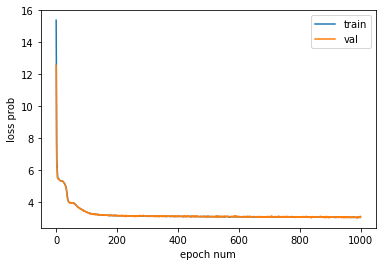

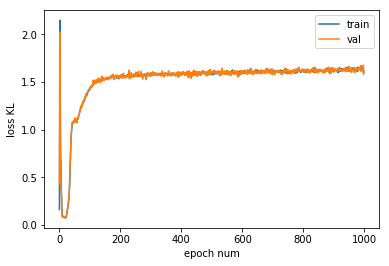

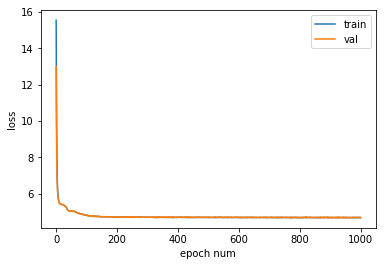

In [19]:
epochs = 1000
lr = 0.001
w_l2 = 0

model = Net2([2, 64, 64, 3])
model.to(device)

criterion_prob = ProbLoss()
criterion_kl = KLLoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion_prob, criterion_kl,
      optimizer, None, epochs,
      train_data2_loader, val_data2_loader)

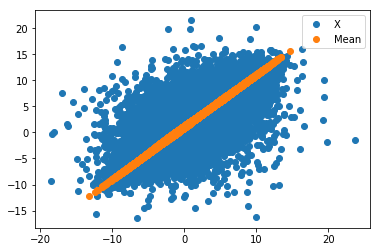

In [20]:
model.eval()
sample(model)

## Part B

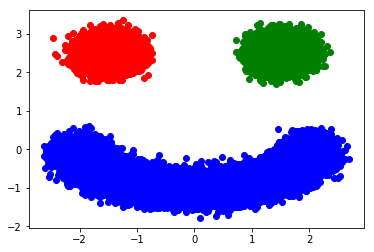

In [21]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

xs3_all, ys3_all = sample_data_3()

for cls, clr in zip([0, 1, 2], 'rgb'):
    plt.plot(xs3_all[ys3_all == cls, 0], xs3_all[ys3_all == cls, 1], clr + 'o')

plt.show()
    
n = xs3_all.shape[0]
n_train = int(n * 0.8)
xs3_train, ys3_train = xs3_all[:n_train], ys3_all[:n_train]
xs3_val, ys3_val = xs3_all[n_train:], ys3_all[n_train:]

In [22]:
batch_size = 10000

def collate_fn(data):
    xs, ys = zip(*data)
    xs = torch.tensor(xs, dtype=torch.float32)
    ys = torch.LongTensor(ys)
    return xs, ys

train_data3_loader = data.DataLoader(
    dataset=list(zip(xs3_train, ys3_train)),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data3_loader = data.DataLoader(
    dataset=list(zip(xs3_val, ys3_val)),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [23]:
def show_latent(model, xs, ys):
    xs = torch.tensor(xs, dtype=torch.float32, device=device)
    with torch.no_grad():
        mu_z, var_z = model.encode(xs)
        eps = eps = torch.randn_like(xs).to(device)
        zs = mu_z + eps * torch.sqrt(var_z)
        zs = zs.cpu().numpy()
        
    for cls, clr in zip([0, 1, 2], 'rgb'):
        plt.plot(zs[ys == cls, 0], zs[ys == cls, 1], clr + 'o')
        
    plt.show()

In [24]:
def prob(x, mu, var):
    prob =  torch.exp(-0.5 * (x - mu) ** 2 / var) / torch.sqrt(np.pi * 2 * var)
    return prob.prod(dim=-1)

def calc_iwae(model, x, k=100):
    with torch.no_grad():
        mu_z, var_z = model.encode(x)
        mu_z, var_z = mu_z[None, :, :], var_z[None, :, :]
        
        eps = torch.randn(k, *x.shape).to(device)
        z = mu_z + eps * torch.sqrt(var_z)
        
        mu_x, var_x = model.decode(z.reshape([-1, 2]))
        mu_x, var_x = mu_x.reshape(z.shape), var_x.reshape(z.shape)

        p_x_z = prob(x, mu_x, var_x)
        p_z = prob(z, torch.zeros_like(mu_z).to(device), torch.ones_like(var_z).to(device))
        q_z_x = prob(z, mu_z, var_z)

        w = ((p_x_z * p_z) / q_z_x).mean(dim=0)
        iwae = torch.log(w).mean()
        return iwae

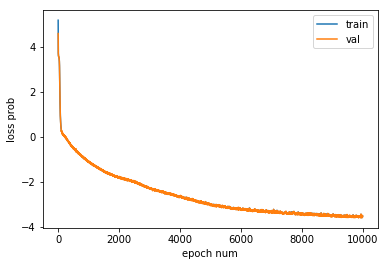

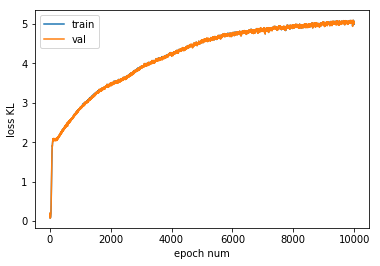

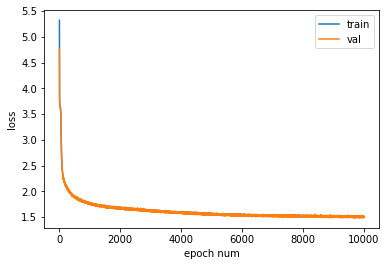

In [25]:
epochs = 10000
lr = 0.0002
w_l2 = 0

model = Net1([2, 512, 4])
model.to(device)

criterion_prob = ProbLoss()
criterion_kl = KLLoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion_prob, criterion_kl,
      optimizer, None, epochs,
      train_data3_loader, val_data3_loader)

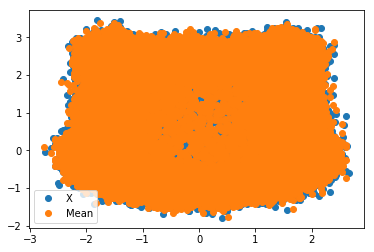

In [26]:
model.eval()
sample(model)

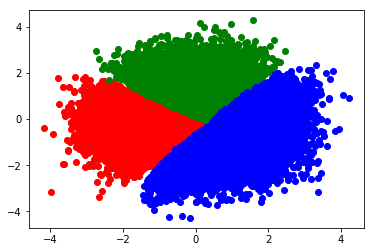

In [27]:
show_latent(model, xs3_all, ys3_all)

In [28]:
xs = torch.tensor(xs3_val[:100], dtype=torch.float32, device=device)
elbo = calc_iwae(model, xs, k=1)
print('ELBO: {:.4f}'.format(elbo.item()))
iwae = calc_iwae(model, xs, k=100)
print('IWAE: {:.4f}'.format(iwae.item()))

ELBO: -1.5417
IWAE: -1.5152
